In [ ]:
# pip install py2neo

## Test Data Preprocessing

In [137]:
import pandas as pd
import os
import json
import numpy as np
from sklearn.metrics import roc_auc_score

directory_path = 'samples_latest'
data = []

for filename in os.listdir(directory_path):
    if filename.endswith('.json'):
        file_path = os.path.join(directory_path, filename)
        
        with open(file_path, 'r') as file:
            file_data = json.load(file)
            data.append(file_data)

symptoms_df = pd.DataFrame(data)
test_df = pd.read_csv('DIA_GROUPS_3_DIGITS_adm_test.csv')
merged_df = pd.merge(symptoms_df, test_df, how='inner', on='id')
merged_df.head(3)

,Symptoms,Diseases,id,icd_9_desc,text,long_texts,short_texts,discharge_summary,short_codes
0,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,"2127,27800,4139,2859,53081,V1083,28860,V8533"
1,"[intermittent L-sided chest pressure, anterior...","[prostate ca s/p brachytherapy, PVD, h/o pancr...",193197,"True posterior wall infarction, initial episod...",CHIEF COMPLAINT: intermittent L-sided chest pr...,"True posterior wall infarction, initial episod...","True post infarct, init,Ac posthemorrhag anemi...",Admission Date: [**2144-2-23**] ...,"41061,2851,41401,4439,V1046,25000"
2,"[palpitations, dizziness, shortness of breath,...","[mitral regurgitation, mitral stenosis, hypert...",157736,"Mitral stenosis with insufficiency,Other chron...",CHIEF COMPLAINT: mitral regurgitation/stenosis...,"Mitral stenosis with insufficiency,Other chron...","Mitral stenosis w insuff,Chr pulmon heart dis ...",Admission Date: [**2197-10-10**] ...,"3942,4168,27800,42731,311,4019,24200"


In [99]:
list(merged_df.iloc[1].Symptoms), merged_df.iloc[1].short_codes.split(',')

(['intermittent L-sided chest pressure',
  'anterior wall chest tightness',
  'SOB',
  'left arm paresthesias',
  'hypertensive',
  'nausea',
  'vomiting',
  'diaphoresis',
  'lightheadedness',
  'dizziness',
  'recurring CP',
  'vagal episode with?apnea-->bagged',
  'chronic hip pain'],
 ['41061', '2851', '41401', '4439', 'V1046', '25000'])

### KG RAG

In [ ]:
import os
from py2neo import Graph
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
from neo4j import GraphDatabase
from dotenv import load_dotenv
import json


uri = "neo4j://localhost:7687" 
auth = ("neo4j", "neo4j_pass2")

driver = GraphDatabase.driver(uri, auth=auth) 
driver.verify_connectivity()

with open('mapped_terms_icd9.json', 'r') as file:
    data = file.read()  # Read the content of the file

# Parse the JSON data
parsed_data = json.loads(data)

result = {}

for key, values in parsed_data.items():
    filtered_diseases = {}
    for value in values:
        disease_info = value['disease'].split(' - ')
        disease_code = disease_info[0].strip()
        disease_desc = disease_info[1].strip()
        euclidean_distance = float(disease_info[2].strip())
        
        if disease_code not in filtered_diseases or filtered_diseases[disease_code]['euclidean_distance'] > euclidean_distance:
            filtered_diseases[disease_code] = {
                'disease_code': disease_code,
                'disease_desc': disease_desc,
                'euclidean_distance': euclidean_distance,
                'pos_weight': value['pos_weight']
            }
    
    result[key] = list(filtered_diseases.values())

with open('output.json', 'w') as f:
    json.dump(result, f, indent=4)

### Graph Creation

In [121]:
# from tqdm import tqdm

# def create_graph(result):
#     with driver.session() as session:
#         for symptom, diseases in tqdm(result.items()):
#             for disease in diseases:
#                 try:
#                     # Extract attributes from disease data
#                     disease_code = disease['disease_code']
#                     disease_desc = disease['disease_desc']
#                     euclidean_distance = float(disease['euclidean_distance'])
#                     pos_weight = int(disease['pos_weight'])
                    
#                     # Create or update Symptom node
#                     session.run("MERGE (s:Symptom {name: $name})", name=symptom)
                    
#                     # Create or update Disease node with attributes
#                     session.run("""
#                         MERGE (d:Disease {name: $name})
#                         ON CREATE SET d.disease_code = $disease_code, d.description = $description
#                         ON MATCH SET d.disease_code = $disease_code, d.description = $description
#                     """, name=disease['disease_code'], disease_code=disease_code, description=disease_desc)
                    
#                     # Create or update the relationship with attributes
#                     session.run("""
#                         MATCH (s:Symptom {name: $symptom}), (d:Disease {name: $disease_code})
#                         MERGE (s)-[r:ASSOCIATED_WITH]->(d)
#                         ON CREATE SET r.euclidean_distance = $euclidean_distance, r.pos_weight = $pos_weight
#                         ON MATCH SET r.euclidean_distance = $euclidean_distance, r.pos_weight = $pos_weight
#                     """, symptom=symptom, disease_code=disease_code, euclidean_distance=euclidean_distance, pos_weight=pos_weight)
#                 except Exception as e:
#                     print(f"An error occurred: {e}")

# create_graph(result)


### Query

In [122]:
def count_distinct_disease_codes():
    with driver.session() as session:
        result = session.run("""
            MATCH (d:Disease)
            RETURN COUNT(DISTINCT d.disease_code) AS distinct_disease_count
        """)
        count = result.single()["distinct_disease_count"]
        return count


distinct_disease_count = count_distinct_disease_codes()
print(f"Number of distinct disease codes in the knowledge graph : {distinct_disease_count}")

Number of distinct disease codes in the knowledge graph : 1888


In [ ]:
def get_distinct_disease_codes():
    with driver.session() as session:
        result = session.run("""
            MATCH (d:Disease)
            RETURN DISTINCT d.disease_code AS disease_code
        """)
        codes = [record["disease_code"] for record in result]
        return codes

distinct_disease_codes = get_distinct_disease_codes()
print(f"Distinct disease codes in the knowledge graph: {distinct_disease_codes}")


In [142]:
distinct_symptoms = set(result.keys())

print(len(distinct_symptoms))

893


In [141]:
symptoms_ddf = merged_df.assign(short_codes=merged_df['Symptoms'].str.split(',')).explode('Symptoms').reset_index(drop =True)
symptoms_ddf.Symptoms.nunique()
len(distinct_symptoms.intersection(set(list(symptoms_ddf.Symptoms))))

11637

In [146]:
len(distinct_symptoms.intersection(set(list(symptoms_ddf.Symptoms))))

192

In [184]:
df = merged_df.assign(short_codes=merged_df['short_codes'].str.split(',')).explode('short_codes').reset_index(drop =True)
df.head()

,Symptoms,Diseases,id,icd_9_desc,text,long_texts,short_texts,discharge_summary,short_codes
0,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,2127
1,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,27800
2,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,4139
3,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,2859
4,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,53081


In [185]:
id_counts = df['id'].value_counts()

ids_with_count_5 = id_counts[id_counts == 5].index

result_df = df[df['id'].isin(ids_with_count_5)].reset_index()

result_df.info()
               

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              655 non-null    int64 
 1   Symptoms           655 non-null    object
 2   Diseases           655 non-null    object
 3   id                 655 non-null    int64 
 4   icd_9_desc         655 non-null    object
 5   text               655 non-null    object
 6   long_texts         655 non-null    object
 7   short_texts        655 non-null    object
 8   discharge_summary  655 non-null    object
 9   short_codes        655 non-null    object
dtypes: int64(2), object(8)
memory usage: 51.3+ KB


In [179]:
merged_df[merged_df.id == 152534]

,Symptoms,Diseases,id,icd_9_desc,text,long_texts,short_texts,discharge_summary,short_codes
3,"[worsening dysphagia, nasal congestion, fatigu...","[myasthenia gravis, left lower lobe pneumonia,...",152534,"Myasthenia gravis with (acute) exacerbation,Pn...",CHIEF COMPLAINT: Worsening dysphagia.\n\nPRESE...,"Myasthenia gravis with (acute) exacerbation,Pn...","Myasthna gravs w ac exac,Pneumonia, organism N...",Admission Date: [**2170-7-11**] ...,"35801,486,2859,7921,311"


In [191]:
df= result_df
df= df.drop('index', axis =1)

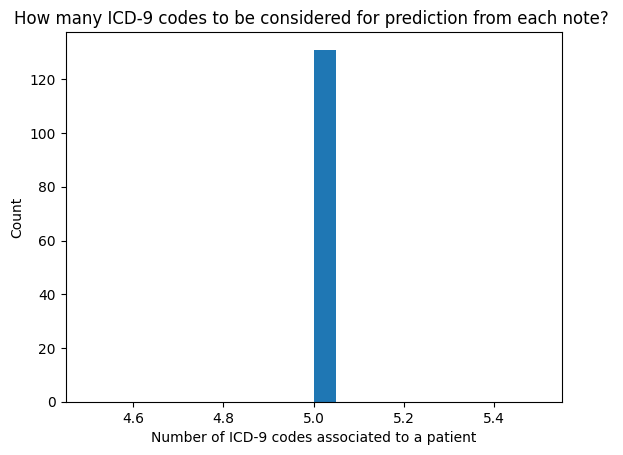

In [192]:
import matplotlib.pyplot as plt
plt.hist(df.id.value_counts(), bins =20)
plt.xlabel('Number of ICD-9 codes associated to a patient')
plt.ylabel('Count')
plt.title('How many ICD-9 codes to be considered for prediction from each note? ')
plt.show()

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Symptoms           655 non-null    object
 1   Diseases           655 non-null    object
 2   id                 655 non-null    int64 
 3   icd_9_desc         655 non-null    object
 4   text               655 non-null    object
 5   long_texts         655 non-null    object
 6   short_texts        655 non-null    object
 7   discharge_summary  655 non-null    object
 8   short_codes        655 non-null    object
dtypes: int64(1), object(8)
memory usage: 46.2+ KB


In [194]:
all_short_codes = set(list(df.short_codes))
print(f'No. of Short Codes : {len(set(all_short_codes))}')
df_one_hot = pd.get_dummies(df, columns=['short_codes'])
df_one_hot.columns = df_one_hot.columns.str.replace('short_codes_', '')
df_one_hot = df_one_hot.drop(['Symptoms', 'Diseases','icd_9_desc', 'text', 'long_texts',
       'short_texts', 'discharge_summary'], axis =1)
df_one_hot = df_one_hot.astype(int)
df_one_hot.head()

No. of Short Codes : 299


,id,03811,03842,04149,07030,07044,07054,1536,1550,1622,...,V4586,V4589,V5332,V5861,V5866,V5867,V5883,V6441,V707,V8801
0,152534,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,152534,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,152534,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,152534,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,152534,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
# from tqdm import tqdm

# def create_graph(parsed_data):
#     with driver.session() as session:
#         for symptom, diseases in tqdm(parsed_data.items()):
#             for disease in diseases:
#                 try:
#                     # Symptom node
#                     session.run("MERGE (s:Symptom {name: $name})", name=symptom)
                    
#                     # Disease node
#                     session.run("MERGE (d:Disease {name: $name})", name=disease['disease'])
                    
#                     # Create a relationship between the symptom and disease with pos_weight
#                     session.run("""
#                         MATCH (s:Symptom {name: $symptom}), (d:Disease {name: $disease})
#                         MERGE (s)-[r:ASSOCIATED_WITH]->(d)
#                         ON CREATE SET r.pos_weight = $pos_weight
#                         ON MATCH SET r.pos_weight = $pos_weight
#                     """, symptom=symptom, disease=disease['disease'], pos_weight=int(disease['pos_weight']))
#                 except Exception as e:
#                     print(f"An error occurred: {e}")

# create_graph(parsed_data)

In [108]:
def delete_all_data():
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
        print("All data has been deleted.")

# delete_all_data()

In [195]:


def get_prioritized_relationships(symptom_names):
    with driver.session() as session:
        result = session.run("""
            MATCH (s:Symptom)-[r:ASSOCIATED_WITH]->(d:Disease)
            WHERE s.name IN $symptoms
            RETURN s.name AS symptom, d.description AS disease_name, d.name AS disease, r.pos_weight AS weight, r.euclidean_distance AS distance
            ORDER BY r.pos_weight DESC, r.euclidean_distance ASC
            LIMIT 50
        """, symptoms=symptom_names)
        
        codes = []
        codes_desc = {}
        all_info = {}
        for record in result:
            # Print or store the disease name and code
            codes.append(f"Disease Name: {record['disease_name']}, ICD-9 code : {record['disease']}")
            codes_desc[f'{record["disease"]}'] = record['disease_name']
            all_info[f'{record["disease"]}'] = [record['disease_name'], record['weight'],record['distance']]
            
        return codes, codes_desc, all_info


def aug_and_gen(codes, symptom) : 
       
#     kg_prompt = f"""
# Given list is the most relevant diseases based on the symptom : {symptom}
#     IMPORTANT : Don't return anything except the python list of ICD-9 codes
#     IMPORTANT : Make sure the codes are in the provided list
#     Your task is to use your knowledge base to identify the most relevant disease among them for the given symptom.
#     Return the top 10 ICD-9 code mentioned in the text for the most relevant disease in python list format :
#     [disease1_code, disease2_code, disease3_code,...]
#     - return only the python list of ICD-9 codes, not even description 
#     - Make sure the codes are in the provided list of disease names and codes
#     - Don't return anything except the python list of codes
#     - Return the top 10 ICD-9 code 
# """
    prompt_start = """You are an AI assistant tasked with identifying the top 5 most relevant ICD-9 codes for a given symptom, based on a provided list of disease names and codes.
Symptom: {symptom}"""
    kg_prompt = """
Relevant Disease Codes:
<<<
[disease1_code, disease2_code, disease3_code,...]
Output the top 5 most relevant ICD-9 codes in the following format:
[
{disease1_code},
{disease2_code},
{disease3_code},
{disease4_code},
{disease5_code},
]
Return only the Python list of ICD-9 codes, not the descriptions
Make sure the codes are in the provided list of disease names and codes
Don't return anything except the Python list of codes
Return the top 5 most relevant ICD-9 codes"""

    model= "open-mistral-nemo-2407" 
    MISTRAL_API_KEY =  "WRhxY4qx7jsun5iYThrdS3Dk4dubsjnV"
    client = MistralClient(api_key=MISTRAL_API_KEY)

    prompt_template = prompt_start + kg_prompt + str(codes)

    chat_response = client.chat(
        model=model,
        max_tokens=200,
        temperature = 0.5,
        messages=[ChatMessage(role="user", content=prompt_template)])



    return chat_response.choices[0].message.content

def codes_n_desc(list_codes, results) : 
    
    try : 
        five_codes = list_codes[2:-2].split("', '")
    except KeyError as s: 
        five_codes = list_codes[2:-2].split(", ")
    except : 
        
        five_codes = list_codes[2:-2].split('", "')
    
    return [(i,results.get(i)) for i in five_codes]


In [ ]:
from tqdm import tqdm

rows_codes = {}
not_matching_rows_codes = []
for j,i in tqdm(merged_df.iterrows()) : 
    symptom = list(merged_df.iloc[j].Symptoms)
    underweight, results, all_infos = get_prioritized_relationships(symptom)
    if len(underweight) !=0:
        list_codes = aug_and_gen(underweight, symptom)
        codes_n_descs = codes_n_desc(list_codes, results)
        # print(codes_n_descs)
        rows_codes[j] = codes_n_descs
    else : 
        print(f'Symptom {symptom} is not in the graph')
        not_matching_rows_codes.append(j)

    if j == 100 :
        break

In [197]:
len(rows_codes.keys())

50

In [ ]:
rows_codes

## AUROC Calculation

In [199]:
auroc_list =[]
for row_num, predicted_results in rows_codes.items() : 

    predicted_labels = [i for i,j in predicted_results]
    # Whether predicted labels are there in the mimic test dataset or not
    available_labels = [str(label) for label in predicted_labels if label in list(df_one_hot.columns)]
    # df_one_hot[available_labels]
    ## Creating a new dataframe with all 2k+ classes
    df = pd.DataFrame(columns=list(df_one_hot.columns))
    df.loc[0] = np.zeros(len(df.columns), dtype=int)
    df = df.astype(int)
    ## Adding +1 for the available labels
    columns_to_increment = list(set(available_labels))
    print(columns_to_increment)
    df.loc[0, columns_to_increment] += 1
    # # True labels 
    # y_true = [1, 0, 0]   
    # # Predicted 
    # y_pred_prob = [1, 0,1]
    # # macro-averaged AUROC
    # auroc_macro = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovr')
    # print(f"Macro-Averaged AUROC: {auroc_macro:.3f}")
    ## mimic labels
    print(row_num)
    true = list(df_one_hot.iloc[row_num,1:])
    ## knowledge graph predicted labels
    pred = list(df.iloc[0,1:])
    # print(true)
    # print(pred)
    auroc_macro = roc_auc_score(true, pred, average='macro', multi_class='ovr')
    auroc_list.append(auroc_macro)
    del df
    print(auroc_macro)
    

['7802']
1
0.4983221476510067
['4271', '7802']
2
0.4966442953020134
[]
3
0.5
[]
4
0.5
['4271']
5
0.4983221476510067
['4271']
6
0.4983221476510067
[]
7
0.5
[]
9
0.5
[]
11
0.5
['4260', '7802']
13
0.4966442953020134
['7802']
17
0.4983221476510067
[]
19
0.5
['496']
24
0.4983221476510067
['5770']
27
0.4983221476510067
[]
31
0.5
['4260', '7802']
33
0.4966442953020134
['7802']
34
0.4983221476510067
['4271', '7802']
35
0.4966442953020134
['3485']
37
0.4983221476510067
[]
39
0.5
['2762']
40
0.4983221476510067
[]
41
0.5
[]
42
0.5
[]
44
0.5
['4271', '7802']
48
0.4966442953020134
[]
49
0.5
[]
50
0.5
['3485']
53
0.4983221476510067
[]
58
0.5
['7802']
59
0.4983221476510067
['4111', '4271', '412']
62
0.4949664429530201
['496']
63
0.4983221476510067
['7802', '4271', '412']
64
0.4949664429530201
[]
65
0.5
['5770']
73
0.4983221476510067
[]
75
0.5
[]
77
0.5
[]
78
0.5
[]
79
0.5
[]
80
0.5
['4271']
81
0.4983221476510067
['5770']
84
0.4983221476510067
[]
86
0.5
['5770']
88
0.4983221476510067
['4271']
89
0.498

In [182]:
np.mean(auroc_list)

0.4995069627399322

In [97]:
df_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6507 entries, 0 to 6506
Columns: 485 entries, id to V851
dtypes: int64(485)
memory usage: 24.1 MB


In [114]:
trueee = list(df_one_hot.iloc[3,1:])

df_one_hot.columns[df_one_hot.iloc[0] == 1].tolist()

['2127']

In [115]:
preddd = [str(label) for label in ['7282', '5641', '4271', '340', '7962', '7804', '7831', '2706', '2872'] if label in list(df_one_hot.columns)] 

df = pd.DataFrame(columns=list(df_one_hot.columns))
df.loc[0] = np.zeros(len(df.columns), dtype=int)
df = df.astype(int)
columns_to_increment = list(set(preddd))
df.loc[0, columns_to_increment] += 1

pred_columns_with_one = df.columns[df.iloc[0] == 1].tolist()
pred_columns_with_one

['2706', '2872', '340', '4271', '5641', '7282', '7804', '7831', '7962']

In [116]:
preddddd = list(df.iloc[0,1:])

In [117]:
len(trueee)
sorted(trueee)[-10:]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [78]:
len(preddddd)

484

In [79]:
# pip install matplotlib

In [80]:
auroc_macro = roc_auc_score(trueee, preddddd, average='macro', multi_class='ovr')
auroc_macro

0.4906832298136646

In [91]:
import numpy as np
from sklearn.metrics import roc_auc_score

def roc_auc(y_true, y_pred_prob, average='macro', multi_class='ovo'):
    """
    Calculate the macro-averaged ROC AUC score for a multi-class classification problem.
    
    Args:
        y_true (list or numpy.ndarray): True labels, with values ranging from 0 to (num_classes - 1).
        y_pred_prob (list or numpy.ndarray): Predicted probabilities for each class, in the format of a 2D array/list.
        average (str, optional): Averaging method for the ROC AUC score. Can be 'macro', 'micro', or 'weighted'. Default is 'macro'.
        multi_class (str, optional): Strategy for handling multi-class problems. Can be 'ovo' (one-vs-one) or 'ovr' (one-vs-rest). Default is 'ovo'.
    
    Returns:
        float: The macro-averaged ROC AUC score.
    """
    if isinstance(y_true, list):
        y_true = np.array(y_true, dtype=int)
    
    return roc_auc_score(y_true=y_true, y_score=y_pred_prob, average='macro', multi_class='ovo')

In [96]:
# True labels 
y_true = [0,0,1,1]
# Predicted 
y_pred_prob = [1, 1, 1, 0]
# macro-averaged AUROC
auroc_macro = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovo')
print(f"Macro-Averaged AUROC: {auroc_macro:.3f}")

Macro-Averaged AUROC: 0.250


In [93]:
auroc_macro = roc_auc(y_true, y_pred_prob, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUROC: {auroc_macro:.3f}")

Macro-Averaged AUROC: 0.494


In [86]:
from sklearn.metrics import f1_score
f1_macro = f1_score(y_true, y_pred_prob, average='macro')

print(f"Macro-Averaged F1-Score: {f1_macro:.3f}")

Macro-Averaged F1-Score: 0.496


In [23]:
# def create_fulltext_indexes():
#     with driver.session() as session:
#         session.run("CALL db.index.fulltext.createNodeIndex('SymptomIndex', ['Symptom'], ['name'])")
#         session.run("CALL db.index.fulltext.createNodeIndex('DiseaseIndex', ['Disease'], ['name'])")

# create_fulltext_indexes()

In [24]:
# def search_symptoms(symptom_name):
#     with driver.session() as session:
#         result = session.run("""
#             CALL db.index.fulltext.queryNodes('SymptomIndex', $symptom_name+'~') YIELD node, score
#             RETURN node.name AS name, score
#             ORDER BY score DESC
#         """, symptom_name=symptom_name)
        
#         return result.data()

# def search_diseases(disease_name):
#     with driver.session() as session:
#         result = session.run("""
#             CALL db.index.fulltext.queryNodes('DiseaseIndex', $disease_name+'~') YIELD node, score
#             RETURN node.name AS name, score
#             ORDER BY score DESC
#         """, disease_name=disease_name)
        
#         return result.data()

# # Example usage
# symptom_search_results = search_symptoms("underweight")
# disease_search_results = search_diseases("HIV")
# print("Symptom Search Results:", symptom_search_results)
# print("Disease Search Results:", disease_search_results)


In [20]:
# get_prioritized_relationships("underweight")

# Test Data Preprocessing

,Symptoms,Diseases,id,icd_9_desc
0,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,..."
1,"[intermittent L-sided chest pressure, anterior...","[prostate ca s/p brachytherapy, PVD, h/o pancr...",193197,"True posterior wall infarction, initial episod..."
2,"[palpitations, dizziness, shortness of breath,...","[mitral regurgitation, mitral stenosis, hypert...",157736,"Mitral stenosis with insufficiency,Other chron..."
3,"[worsening dysphagia, nasal congestion, fatigu...","[myasthenia gravis, left lower lobe pneumonia,...",152534,"Myasthenia gravis with (acute) exacerbation,Pn..."
4,"[severe abdominal pain, nausea, diaphoresis, c...","[colon cancer, hypertension, MI x 2, extensive...",119136,"Other postoperative infection,Perforation of i..."


,id,text,long_texts,short_texts,discharge_summary,short_codes
0,116159,CHIEF COMPLAINT: Positive ETT\n\nPRESENT ILLNE...,Coronary atherosclerosis of native coronary ar...,"Crnry athrscl natve vssl,Aortic valve disorder...",Admission Date: [**2197-6-5**] D...,"414,424,287,600,272,401,412,427,443,V458"
1,109813,CHIEF COMPLAINT: Repeated small bowel obstruct...,"Nodular lymphoma, unspecified site, extranodal...","Ndlr lym unsp xtrndl org,Intestinal obstruct N...",Admission Date: [**2165-12-19**] ...,"202,560,427,424,397,285,401,530"
2,173128,CHIEF COMPLAINT: Visual changes and CT finding...,"Intracerebral hemorrhage,Cerebral edema,Other ...","Intracerebral hemorrhage,Cerebral edema,Amyloi...",Admission Date: [**2171-11-14**] ...,"431,348,277,599,368,781,784,401,788,272,437,493"
3,179683,CHIEF COMPLAINT: 1. Aspiration pneumonia requi...,Injury to other intra-abdominal organs without...,"Biliary tract injury-cl,Obstruction of bile du...",Admission Date: [**2201-6-17**] ...,"868,576,518,902,997,276,E876,E849,V457,V105,V1..."
4,117062,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,Acute myocardial infarction of anterolateral w...,"AMI anterolateral, init,Cardiogenic shock,Atri...",Admission Date: [**2130-10-4**] Discharge...,"410,785,427,458,294,401"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Symptoms    2686 non-null   object
 1   Diseases    2686 non-null   object
 2   id          2686 non-null   int64 
 3   icd_9_desc  2686 non-null   object
dtypes: int64(1), object(3)
memory usage: 84.1+ KB


,Symptoms,Diseases,id,icd_9_desc,text,long_texts,short_texts,discharge_summary,short_codes
0,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,"212,278,413,285,530,V108,288,V853"
1,"[intermittent L-sided chest pressure, anterior...","[prostate ca s/p brachytherapy, PVD, h/o pancr...",193197,"True posterior wall infarction, initial episod...",CHIEF COMPLAINT: intermittent L-sided chest pr...,"True posterior wall infarction, initial episod...","True post infarct, init,Ac posthemorrhag anemi...",Admission Date: [**2144-2-23**] ...,"410,285,414,443,V104,250"
2,"[palpitations, dizziness, shortness of breath,...","[mitral regurgitation, mitral stenosis, hypert...",157736,"Mitral stenosis with insufficiency,Other chron...",CHIEF COMPLAINT: mitral regurgitation/stenosis...,"Mitral stenosis with insufficiency,Other chron...","Mitral stenosis w insuff,Chr pulmon heart dis ...",Admission Date: [**2197-10-10**] ...,"394,416,278,427,311,401,242"
3,"[worsening dysphagia, nasal congestion, fatigu...","[myasthenia gravis, left lower lobe pneumonia,...",152534,"Myasthenia gravis with (acute) exacerbation,Pn...",CHIEF COMPLAINT: Worsening dysphagia.\n\nPRESE...,"Myasthenia gravis with (acute) exacerbation,Pn...","Myasthna gravs w ac exac,Pneumonia, organism N...",Admission Date: [**2170-7-11**] ...,"358,486,285,792,311"
4,"[severe abdominal pain, nausea, diaphoresis, c...","[colon cancer, hypertension, MI x 2, extensive...",119136,"Other postoperative infection,Perforation of i...",CHIEF COMPLAINT: bilious output from drains fo...,"Other postoperative infection,Perforation of i...","Other postop infection,Perforation of intestin...",Admission Date: [**2105-8-13**] ...,"998,569,518,276,511,568,041,E878,V553,285,427,..."


In [214]:
y_true = [0, 1, 2]  
# Predicted 
y_pred_prob = [[1,0,0],[0,1,0],[0,0,1]]
# macro-averaged AUROC
auroc_macro = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovo')
print(f"Macro-Averaged AUROC: {auroc_macro:.3f}")

Macro-Averaged AUROC: 1.000


In [219]:
y_true = [1, 0, 2]

y_pred_prob = [[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]]


y_pred_prob = np.array(y_pred_prob)


auroc_macro = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUROC: {auroc_macro:.3f}")

Macro-Averaged AUROC: 0.500
